In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# Tutorial 1: Defining a Camera

The first step in creating a sstcam-simulation script is defining the camera. The description of a Camera in the sstcam-simulation package is contained within the `Camera` class. This is simply a container for the different aspects important for the simulation processing. This notebook describes some of the more complex contents of the `Camera` class.

In [2]:
from sstcam_simulation import Camera
Camera?

Init signature:
Camera(
    continuous_readout_duration: int = 1000,
    n_waveform_samples: int = 128,
    trigger_threshold: float = 2,
    digital_trigger_length: float = 8,
    lookback_time: float = 20,
    mapping: sstcam_simulation.camera.mapping.SSTCameraMapping = <sstcam_simulation.camera.mapping.SSTCameraMapping object at 0x7fae74180b50>,
    photoelectron_pulse: sstcam_simulation.camera.pulse.PhotoelectronPulse = <sstcam_simulation.camera.pulse.GaussianPulse object at 0x7fae74185350>,
    reference_pulse: sstcam_simulation.camera.pulse.PhotoelectronPulse = <property object at 0x7fae74132170>,
    photoelectron_spectrum: sstcam_simulation.camera.spe.SPESpectrum = <sstcam_simulation.camera.spe.SiPMGentileSPE object at 0x7fae739c7f90>,
    readout_noise: sstcam_simulation.camera.noise.ElectronicNoise = <sstcam_simulation.camera.noise.PerfectElectronics object at 0x7fae741168d0>,
    digitisation_noise: sstcam_simulation.camera.noise.ElectronicNoise = <sstcam_simulation.camera.n

## Defaults

All aspects of the `Camera` have a default value, and a reasonable description of the camera can be easily obtained to explore the other aspects of this camera.

In [3]:
camera = Camera()
print(camera)

Camera(continuous_readout_duration=1000, n_waveform_samples=128, trigger_threshold=2, digital_trigger_length=8, lookback_time=20, mapping=<sstcam_simulation.camera.mapping.SSTCameraMapping object at 0x7fae74180b50>, photoelectron_pulse=<sstcam_simulation.camera.pulse.GaussianPulse object at 0x7fae74185350>, reference_pulse=<sstcam_simulation.camera.pulse.GaussianPulse object at 0x7fae74185350>, photoelectron_spectrum=<sstcam_simulation.camera.spe.SiPMGentileSPE object at 0x7fae739c7f90>, readout_noise=<sstcam_simulation.camera.noise.PerfectElectronics object at 0x7fae741168d0>, digitisation_noise=<sstcam_simulation.camera.noise.PerfectElectronics object at 0x7fae74116850>, coupling=<sstcam_simulation.camera.coupling.NoCoupling object at 0x7fae74116450>)


/Users/Jason/Software/sstcam-simulation/sstcam_simulation/camera/camera.py:42: DeprecationWarning: reference_pulse is deprecated, replaced by photoelectron_pulse
  warnings.warn(msg, DeprecationWarning)


In [4]:
type(camera.photoelectron_spectrum) is property

False

In [5]:
type(property)

type

# Continuous Readout

As true continuous readout would be very dificult to simulate, an emulation of it is attempted with a readout that is longer than a typical waveform length, and is more finely samples (with sample widths of 0.2 ns).

The readout length (in nanoseconds) is defined with the `continuous_readout_duration` argument.

In [6]:
camera = Camera()
print("default continuous_readout_duration = ", camera.continuous_readout_duration)

default continuous_readout_duration =  1000


In [7]:
camera = Camera(continuous_readout_duration=20000)
print("continuous_readout_duration = ", camera.continuous_readout_duration)

continuous_readout_duration =  20000


The sample width and a time axis for the continuous readout can be accessed through properties of the `Camera`

In [8]:
print(camera.continuous_readout_sample_width)

0.2


In [9]:
print(camera.continuous_readout_time_axis)

[0.00000e+00 2.00000e-01 4.00000e-01 ... 1.99994e+04 1.99996e+04
 1.99998e+04]


## Pixel/Superpixel Mapping

The `SSTCameraMapping` class contains information about the camera mapping and pixel neighbours. It can also be used to create `CameraImage` plots (inherted from CHECLabPy).

In [10]:
from sstcam_simulation.camera import SSTCameraMapping
SSTCameraMapping?

Init signature: SSTCameraMapping(n_pixels=None)
Docstring:      <no docstring>
Init docstring:
Container for the camera coordinates of the SST Camera, and the mapping
between different coordinate sets (e.g. pixel to superpixel)

Parameters
----------
n_pixels : int
    Number of pixels in the simulated camera

Attributes
----------
self.n_pixels : int
    Number of pixels in the simulated camera
self.pixel : CameraCoordinate
    Container for the pixel coordinates
self.pixel_to_superpixel : ndarray
    Superpixel index for each pixel. Shape: (n_pixels)
self.n_superpixels : int
    Number of superpixels in the simulated camera
self.superpixel : CameraCoordinate
    Container for the superpixel coordinates
File:           ~/Software/sstcam-simulation/sstcam_simulation/camera/mapping.py
Type:           type
Subclasses:     


Total number of pixel neighbours =  7910


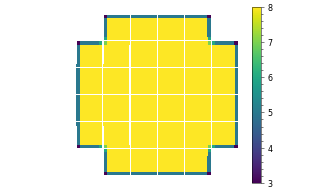

In [11]:
from sstcam_simulation.plotting import CameraImage

camera = Camera()
camera_image = CameraImage.from_coordinates(camera.mapping.pixel)
print("Total number of pixel neighbours = ", len(camera.mapping.pixel.neighbours))
n_neighbours = np.zeros(camera.mapping.n_pixels)
np.add.at(n_neighbours, camera.mapping.pixel.neighbours, 1)
camera_image.image = n_neighbours
camera_image.add_colorbar()

Total number of superpixel neighbours =  1910


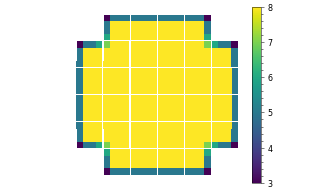

In [12]:
camera = Camera()
camera_image = CameraImage.from_coordinates(camera.mapping.superpixel)
print("Total number of superpixel neighbours = ", len(camera.mapping.superpixel.neighbours))
n_neighbours = np.zeros(camera.mapping.n_superpixels)
np.add.at(n_neighbours, camera.mapping.superpixel.neighbours, 1)
camera_image.image = n_neighbours
camera_image.add_colorbar()

One can specify a camera with as many pixels as it required (e.g. 1 pixel, 4 pixels, 64 pixels...). The number of superpixels is calculated accounting for this configuration.

N_pixels =  1
N_superpixels =  1
Total number of pixel neighbours =  0


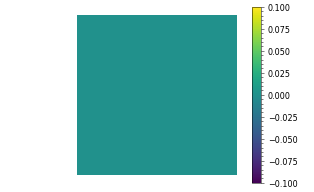

In [13]:
camera = Camera(mapping=SSTCameraMapping(n_pixels=1))
print("N_pixels = ", camera.mapping.n_pixels)
print("N_superpixels = ", camera.mapping.n_superpixels)

camera_image = CameraImage.from_coordinates(camera.mapping.pixel)
print("Total number of pixel neighbours = ", len(camera.mapping.pixel.neighbours))
n_neighbours = np.zeros(camera.mapping.n_pixels)
np.add.at(n_neighbours, camera.mapping.pixel.neighbours, 1)
camera_image.image = n_neighbours
camera_image.add_colorbar()

## Photoelectron Pulse

The `PhotoelectronPulse` is a base for classes which defines the reference pulse shape of a single photoelectron. When obtaining the camera readout, this pulse shape is convolved with the photoelectrons. The `ReferencePulse` subclass defines the `_function` method, which returns the pulse shape when given the an ndarray containing time values. The `__init__` for a `PhotoelectronPulse` subclass takes in whatever paramters needed to describe the pulse, in addition to the `length` argument, which defines the length for the reference pulse (in nanoseconds). From the definition in `_function` and the configuration arguments to `__init__`, the reference pulse array is generated ready to be used in the convolution.

By default the reference pulse is normalised to have an area of 1. Therefore an integration of the resulting waveform results in charge units of photoelectrons. By specifying `mv_per_pe` as an argument to the `PhotoelectronPulse` subclass, the height of the pulse is fixed, and the units of the waveform samples can be considered to be in mV.

In [14]:
from sstcam_simulation.camera.pulse import PhotoelectronPulse, GaussianPulse
PhotoelectronPulse?

Init signature: PhotoelectronPulse(duration, mv_per_pe=None)
Docstring:      <no docstring>
Init docstring:
Base for classes which define the reference pulse shape for a single
photoelectron.

The pulse is evaluated on initialisation.
For a new pulse to be defined, a new class should be initialised.

Parameters
----------
duration : int
    Duration of the reference pulse in nanoseconds
mv_per_pe : float
    Height of a 1 photoelectron pulse in mV. If this is set, then the
    units of the waveform samples can be globally considered as mV
    instead of photoelectrons/sample.
    If this is None, then the height of a 1 photoelectron pulse is
    determined such that the pulse area is 1
File:           ~/Software/sstcam-simulation/sstcam_simulation/camera/pulse.py
Type:           ABCMeta
Subclasses:     ReferencePulse, GenericPulse, GaussianPulse


In [15]:
def show_pulse(pulse):
    camera = Camera(photoelectron_pulse=pulse)
    plt.plot(camera.photoelectron_pulse.time, camera.photoelectron_pulse.amplitude)
    plt.xlabel("Time (ns)")
    _ = plt.ylabel("Amplitude")
    print(f"Height = {pulse.height:.2f}, Area = {pulse.area:.2f}")

Height = 0.13, Area = 1.00


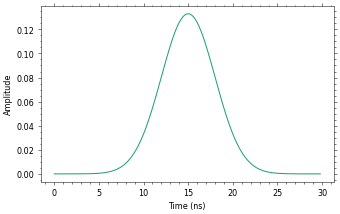

In [16]:
show_pulse(GaussianPulse(mean=15, sigma=3, duration=30))

Height = 0.08, Area = 1.00


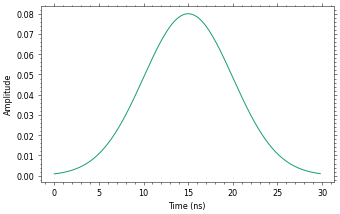

In [17]:
show_pulse(GaussianPulse(mean=15, sigma=5, duration=30))

Height = 4.00, Area = 30.08


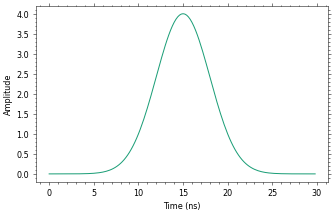

In [18]:
show_pulse(GaussianPulse(mean=15, sigma=3, duration=30, mv_per_pe=4))

## SPE Spectrum

The `SPESpectrum` class is the base for classes which define the Probability Density Function for the possible charges a photosensor can report a single photoelectron as. Very similar to the `ReferencePulse` classes, the `_function` methods of the subclass defines the spectrum for different x values. The `__init__` takes arguments which configure the spectrum, and also the `x_min`, `x_max`, and `n_points`, to define the sampling of the spectrum. During the simulation, this spectrum is used with `np.random.choice` to perform [Inverse Transform Sampling](https://en.wikipedia.org/wiki/Inverse_transform_sampling) to obtain a random value of charge weighted by the spectrum.

The spectrum is normalised to have an integral of 1, and to return an average charge of 1 (such that the units of charge are in photoelectrons).

In [19]:
from sstcam_simulation.camera.spe import SPESpectrum, SiPMGentileSPE
SPESpectrum?

Init signature: SPESpectrum(x_min, x_max, n_points)
Docstring:      <no docstring>
Init docstring:
Base for classes which define the probability density function of the
charge for a single photoelectron.

NOTE: this is **not** the spectrum for an "average illumination" i.e. a Poisson
average close to one. This is the probability density function of the
possible charges a single photoelectron can be measured as. This spectrum
therefore defines the Excess Noise Factor (ENF) of the photosensor. Also,
by definition, it does not include the pedestal peak.

The spectrum is evaluated on initialisation.
For a new spectrum to be defined, a new class should be initialised.

Parameters
----------
x_min : float
    Minimum charge at which the spectrum is defined (Unit: p.e.)
x_max : float
    Maximum charge at which the spectrum is defined (Unit: p.e.)
n_points: int
    Number of points between x_min and x_max used to define the spectrum
File:           ~/Software/sstcam-simulation/sstcam_simulati

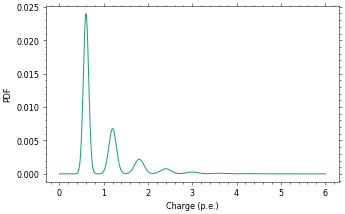

In [20]:
spe_spectrum = SiPMGentileSPE(spe_sigma=0.1, opct=0.4, x_min=0, x_max=10, n_points=1000)
camera = Camera(photoelectron_spectrum=spe_spectrum)
plt.plot(camera.photoelectron_spectrum.x, camera.photoelectron_spectrum.pdf)
plt.xlabel("Charge (p.e.)")
_ = plt.ylabel("PDF")

## Electronic Noise

The `ElectronicNoise` class is the base for classes which define the electronic noise spectrum and fluctuations to be applied to the camera readout and waveform. The tranformation applied to the readout is defined in the `add_to_readout` method in the subclass. This method takes only the `readout` as an argument. The configuration for the electronic noise spectrum is defined in arguments to the `__init__` of the subclass.

There are two arguments to the `Camera` that take an `ElectronicNoise` subclass. Which one is used depends on the desired stage of the readout chain for the application:
- `readout_noise`: Applies the fluctuations to the continuous readout (pre-sampling)
- `digitisation_noise`: Applies the fluctuations to the waveform samples (post-sampling). Not present for trigger discrimination.

Further details on the readout chain stages are decribed in the 3_event_acquisition tutorial.

In [21]:
from sstcam_simulation.camera.noise import ElectronicNoise, GaussianNoise
ElectronicNoise?

Init signature: ElectronicNoise()
Docstring:     
Base for classes which define an electronic noise spectrum, and how it is
applied to the waveform

Can be used for any of the noise components
File:           ~/Software/sstcam-simulation/sstcam_simulation/camera/noise.py
Type:           ABCMeta
Subclasses:     PerfectElectronics, GaussianNoise


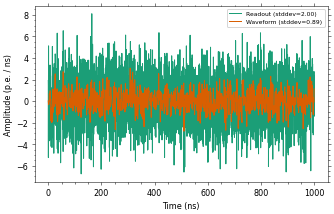

In [22]:
from sstcam_simulation import Photoelectrons, EventAcquisition

stddev = 2
camera = Camera(readout_noise=GaussianNoise(stddev=stddev), n_waveform_samples=1000)
pe = Photoelectrons.empty()
acq = EventAcquisition(camera=camera)
readout = acq.get_continuous_readout(pe)
waveform = acq.get_sampled_waveform(readout)
plt.plot(camera.continuous_readout_time_axis, readout[0], label=f"Readout (stddev={readout.std():.2f})")
plt.plot(waveform[0], label=f"Waveform (stddev={waveform.std():.2f})")
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude (p.e. / ns)")
_ = plt.legend(loc='best')

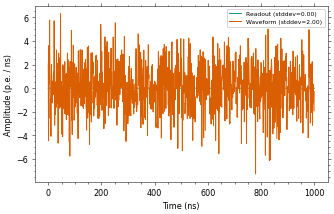

In [23]:
stddev = 2
camera = Camera(digitisation_noise=GaussianNoise(stddev=stddev), n_waveform_samples=1000)
pe = Photoelectrons.empty()
acq = EventAcquisition(camera=camera)
readout = acq.get_continuous_readout(pe)
waveform = acq.get_sampled_waveform(readout)
plt.plot(camera.continuous_readout_time_axis, readout[0], label=f"Readout (stddev={readout.std():.2f})")
plt.plot(waveform[0], label=f"Waveform (stddev={waveform.std():.2f})")
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude (p.e. / ns)")
_ = plt.legend(loc='best')

If a standard-deviation of fluctuations is applied via the `readout_noise` parameter, the fluctuations of the final sampled waveform can be predicted analytically as follows:

In [24]:
stddev = 2
camera = Camera(readout_noise=GaussianNoise(stddev=stddev), n_waveform_samples=1000)
pe = Photoelectrons.empty()
acq = EventAcquisition(camera=camera)
readout = acq.get_continuous_readout(pe)
waveform = acq.get_sampled_waveform(readout)
print(readout.std())
print(waveform.std())
print(stddev/np.sqrt(camera.continuous_readout_sample_division))

2.000251244121317
0.8943583928345934
0.8944271909999159
